### Importações das bibliotecas


In [1]:
# serialização de dados
import pickle

# tratamento e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# divisão em treino e teste, escalona e faz encoding de variáveis categóricas
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE

# Discretização de features
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser

# métricas de performance de modelos
# classification_report, accuracy_score, f1_score, average_precision_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# importamos a árvore de decisão
from sklearn.tree import DecisionTreeClassifier
# importando randomforestclassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# importando o classificador XGBoost
from xgboost import XGBClassifier
# Importando o classificador Support Vector Machines
from sklearn.svm import SVC

# Para a Validação Cruzada
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Tunagem de Hiperparâmetros
import optuna

g:\Program Files (x86)\Python 3 11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importando a base de dados

In [2]:
with open('EDA_df.pkl', mode='rb') as f:
    df = pickle.load(f)

### Funções que utilizaremos

In [52]:
# Treina o modelo, exibe precisão/recall, matriz de confusão, feature_importance
# retorna o modelo treinado, X_test, y_test, y_pred
def treinar_modelo(modelo, X: pd.DataFrame, y: pd.Series, report: bool=False, feature_importance_report: bool=False) -> str:      
    # Criando o StratifiedKFold
    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=47)

    # Definindo um pipeline com StandardScaler e LogisticRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('modelo', modelo)
    ])

    # Definindo as métricas
    scoring = ['precision_weighted', 'recall_weighted']

    # Calculando as métricas usando cross_validate
    scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
        
    # treinando o modelo para obter a matriz de confusao
    train_index, test_index = next(skf.split(X,y))
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    if report:
        
        # Exibindo as métricas finais
        print(f"Média da Precisão (Weighted): {scores['test_precision_weighted'].mean():.3f}")
        print(f"Média da Revocação (Weighted): {scores['test_recall_weighted'].mean():.3f}")
            
        # plotando a matriz de confusão da cross_validate
        matriz_confusao = confusion_matrix(y_test, y_pred)
        sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')

        # Configurações do gráfico
        plt.title('Matriz de confusão')
        plt.xlabel('Valor Predito')
        plt.ylabel('Valor Real')
        plt.show();

    if feature_importance_report:
        # Acessando a importância das features
        if hasattr(pipeline.named_steps['modelo'], 'feature_importances_'):
            feature_importances = pipeline.named_steps['modelo'].feature_importances_
            importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
            importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
            print(importances_df)
            
    return pipeline, X_test, y_test, y_pred


# Relatório de Recursive Feature Elimination
def rfe_report(modelo, min_range: int=13, max_range: int=25):
    # Definir o StratifiedKFold com 2 folds
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=47)
    
    # Loop sobre os folds do StratifiedKFold para obter os splits estratificados
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # instanciamos o RFE
    selector = RFE(estimator=modelo)
    
    # Identificar as features selecionadas
    X_train_df = pd.DataFrame(X_train)
    
    # Instanciando variáveis controle:
    melhor_pr_auc = 0
    
    
    for qtd_features in range(min_range, max_range+1, 2):
        # definimos o número de features que devem permanecer
        selector.n_features_to_select = qtd_features

        # Executar RFE no fold de treino
        selector.fit(X_train, y_train)
        features_selecionadas = selector.support_

        # Filtrar as features selecionadas
        X_train_selecionado = X_train.loc[:, features_selecionadas]
        X_test_selecionado = X_test.loc[:, features_selecionadas]

        # Treinar o modelo com as features selecionadas
        modelo.fit(X_train_selecionado, y_train)

        # Prever probabilidades no fold de teste
        y_pred_proba = modelo.predict_proba(X_test_selecionado)[:, 1]

        # Calcular a curva Precision-Recall e AUC
        precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
        metrica_pr_auc = auc(revocacao, precisao)
        nome_features_selecionadas = [X_train_df.columns[i] for i, item in enumerate(features_selecionadas) if item]  

        # Comparar e atualizar o melhor resultado encontrado
        if metrica_pr_auc > melhor_pr_auc:
            melhor_pr_auc = metrica_pr_auc
            # Comparar e atualizar o melhor modelo encontrado
            if metrica_pr_auc > melhor_pr_auc:
                melhor_modelo_n_features = qtd_features
                melhores_features = nome_features_selecionadas.copy()
                melhor_pr_auc = metrica_pr_auc
                melhor_modelo = modelo
        # exibe as informações do RFE atual
        print('----------------------------------------------')
        print(f'RFE com {qtd_features} features:')
        print('[INFO] Precision Recall AUC: ', metrica_pr_auc)
        print("[INFO] Features selecionadas: ", nome_features_selecionadas)
    # exibe as informações do melhor RFE
    print('----------------------------------------------')
    print(f'MELHOR MODELO com {melhor_modelo_n_features} features:')
    print('[END] Precision Recall AUC: ', melhor_pr_auc)
    print("[END] Features selecionadas: ", melhores_features)
    
    # retorna o modelo com melhor rfe
    return melhor_modelo

# Modelagem
### Feature Engineering
Utilizaremos:
- EqualFrequencyDiscretiser: criando bins/intervalos com base em uma feature;
- LabelEncoder: transformando subcategorias em inteiros;
- Médias e desvios-padrão de features; e
- ratios: divisão de uma feature por outra

In [ ]:
# Verificando a Correlação de Pearson para as variáveis do dataset
plt.figure(figsize=(12,18))
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calcular a matriz de correlação de Pearson
corr_matrix = df[numeric_cols].corr()

sns.heatmap(data=corr_matrix,annot=True, cmap='RdYlGn', vmin=-1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=10, ha='right', fontsize=7)
plt.yticks(rotation=90, fontsize=7)
plt.title('Matriz de Correlação de Pearson')
plt.tight_layout()
plt.show();

Podemos observar uma forte correlação entre as variáveis ... inserir análise da correlação aqui. Com base nisso, criaremos as seguintes features:
 1. retorno_emprestimo = multiplicando (taxa_juros_emprestimo por valor_emprestimo) + valor_empréstimo;
 2. ratio_renda_emp = dividindo renda por emprestimo;
 3. ratio_emprego_credito = tempo_emprego_cliente dividido por tempo_credito_cliente, caso dividir por zero, resulta em zero;
 4. media_valemp_nota = média de valor_emprestimo para cada nota_emprestimo;
 5. media_valoremp_finalidade = média de valor_emprestimo para cada finalidade_emprestimo;
 6. std_valemp_residencia = desvio-padrão do valor_emprestimo por posse_residencia_cliente;
 7. media_renda_nota = média de renda_cliente para cada nota_emprestimo;
 8. media_renda_finalidade = média de renda_cliente para cada finalidade_emprestimo;
 9. std_renda_residencia = desvio-padrão do renda_cliente por posse_residencia_cliente;
 10. EFD_idade = dividindo a coluna idade_cliente em intervalos por frequência igual;
 11. EFD_tempo_emprego = dividindo a coluna tempo_emprego_cliente em intervalos por frequência igual;
 12. EFD_tempo_credito = dividindo a coluna tempo_credito_cliente em intervalos por frequência igual;
 13. EFD_valor_emprestimo = dividindo a coluna valor_emprestimo em intervalos por frequência igual;
 14. EFD_renda_cliente = dividindo a coluna renda_cliente em intervalos por frequência igual; e
 15. EFD_taxa_juros = dividindo a coluna taxa_juros_emprestimo em intervalos por frequência igual.

In [4]:
# 1. 
df['retorno_emprestimo'] = df['valor_emprestimo'] * (df['taxa_juros_emprestimo'] / 100 + 1)
# 2.
df['ratio_renda_emp'] = df['renda_cliente'] / df['valor_emprestimo']
# 3. 
df['ratio_emprego_credito'] = df['tempo_emprego_cliente'] / df['tempo_credito_cliente']
# 4.
df['media_valemp_nota'] = df.groupby(['nota_emprestimo'])['valor_emprestimo'].transform('mean')
# 5.
df['media_valemp_finalidade'] = df.groupby(['finalidade_emprestimo'])['valor_emprestimo'].transform('mean')
# 6.
df['std_valemp_residencia'] = df.groupby(['posse_residencia_cliente'])['valor_emprestimo'].transform('std')
# 7.
df['media_renda_nota'] = df.groupby(['nota_emprestimo'])['renda_cliente'].transform('mean')
# 8.
df['media_renda_finalidade'] = df.groupby(['finalidade_emprestimo'])['renda_cliente'].transform('mean')
# 9.
df['std_renda_residencia'] = df.groupby(['posse_residencia_cliente'])['renda_cliente'].transform('std')
# 10-15. Instanciando o discretizador
efd_disc = EqualFrequencyDiscretiser() #EqualWidthDiscretiser(bins=5)

# Ajustando o discretizador aos dados
try:
    # Ajustando o discretizador aos dados
    df['EFD_idade'] = efd_disc.fit_transform(df[['idade_cliente']])
    df['EFD_tempo_emprego'] = efd_disc.fit_transform(df[['tempo_emprego_cliente']])
    df['EFD_tempo_credito'] = efd_disc.fit_transform(df[['tempo_credito_cliente']])
    # 18JUL24 feature engineering
    df['EFD_valor_emprestimo'] = efd_disc.fit_transform(df[['valor_emprestimo']])
    df['EFD_renda_cliente'] = efd_disc.fit_transform(df[['valor_emprestimo']])
    df['EFD_taxa_juros'] = efd_disc.fit_transform(df[['valor_emprestimo']])
except Exception as e:
    print(f"Erro ao aplicar o EqualFrequencyDiscretiser: {e}")



In [5]:
df.dtypes

idade_cliente                        int16
renda_cliente                        int64
posse_residencia_cliente            object
tempo_emprego_cliente                int16
finalidade_emprestimo               object
nota_emprestimo                     object
valor_emprestimo                     int64
taxa_juros_emprestimo              float32
percentual_renda_emprestimo        float32
historico_inadimplencia_cliente      int16
tempo_credito_cliente                int16
status_emprestimo                    int16
retorno_emprestimo                 float64
ratio_renda_emp                    float64
ratio_emprego_credito              float64
media_valemp_nota                  float64
media_valemp_finalidade            float64
std_valemp_residencia              float64
media_renda_nota                   float64
media_renda_finalidade             float64
std_renda_residencia               float64
EFD_idade                            int64
EFD_tempo_emprego                    int64
EFD_tempo_c

In [6]:
# verificando os intervalos criados para a idade
df.groupby('EFD_idade').agg({'idade_cliente':['mean','min','max', 'size']})

idade_cliente              
                   mean min max  size
EFD_idade                            
0             21.740547  20  22  4390
1             23.000000  23  23  3518
2             24.000000  24  24  3214
3             25.000000  25  25  2783
4             26.000000  26  26  2256
5             27.000000  27  27  1925
6             28.478288  28  29  3201
7             30.904096  30  32  3076
8             34.310303  33  36  2475
9             42.468374  37  84  2577

In [7]:
# verificando os intervalos criados para o tempo de serviço
df.groupby('EFD_tempo_emprego').agg({'tempo_emprego_cliente':['mean','min','max', 'size']})

tempo_emprego_cliente              
                                   mean min max  size
EFD_tempo_emprego                                    
0                              0.368098   0   1  7172
1                              2.000000   2   2  3463
2                              3.000000   3   3  3130
3                              4.000000   4   4  2569
4                              5.000000   5   5  2712
5                              6.000000   6   6  2392
6                              7.437679   7   8  3498
7                              9.339806   9  10  1854
8                             13.745524  11  41  2625

In [8]:
# verificando os intervalos criados para o tempo de crédito em registro
df.groupby('EFD_tempo_credito').agg({'tempo_credito_cliente':['mean','min','max', 'size']})

tempo_credito_cliente               
                                   mean min max   size
EFD_tempo_credito                                     
0                              2.499907   2   3  10770
1                              4.000000   4   4   5393
2                              5.000000   5   5   1699
3                              6.505009   6   7   3394
4                              8.499853   8   9   3407
5                             10.199430  10  11   2106
6                             15.270975  12  30   2646

In [9]:
# visualizando o dataset após implementação
df.head(15)

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,EFD_idade,EFD_tempo_emprego,EFD_tempo_credito,EFD_valor_emprestimo,EFD_renda_cliente,EFD_taxa_juros
0,22,59000,Alugada,23,Pessoal,D,35000,16.020000,0.59,1,...,5814.229899,63193.286405,65187.707459,31495.813457,0,8,0,9,9,9
1,21,9600,Própria,5,Educação,B,1000,11.140000,0.10,0,...,6200.190887,65034.454516,63593.200957,41373.782824,0,4,0,0,0,0
2,25,9600,Hipoteca,1,Médico,C,5500,12.870000,0.57,0,...,6770.406753,62525.863089,59818.228309,46037.084190,3,0,0,3,3,3
3,23,65500,Alugada,4,Médico,C,35000,15.230000,0.53,0,...,5814.229899,62525.863089,59818.228309,31495.813457,1,3,0,9,9,9
4,24,54400,Alugada,8,Médico,C,35000,14.270000,0.55,1,...,5814.229899,62525.863089,59818.228309,31495.813457,2,6,1,9,9,9
5,21,9900,Própria,2,Empreendimento,A,2500,7.140000,0.25,0,...,6200.190887,65154.163508,65236.276083,41373.782824,0,1,0,0,0,0
6,26,77100,Alugada,8,Educação,B,35000,12.420000,0.45,0,...,5814.229899,65034.454516,63593.200957,31495.813457,4,6,0,9,9,9
7,24,78956,Alugada,5,Médico,B,35000,11.110000,0.44,0,...,5814.229899,65034.454516,59818.228309,31495.813457,2,4,1,9,9,9
8,24,83000,Alugada,8,Pessoal,A,35000,8.900000,0.42,0,...,5814.229899,65154.163508,65187.707459,31495.813457,2,6,0,9,9,9
9,21,10000,Própria,6,Empreendimento,D,1600,14.740000,0.16,0,...,6200.190887,63193.286405,65236.276083,41373.782824,0,5,0,0,0,0


In [10]:
# instanciando o LabelEncoder
label_encoder_residencia = LabelEncoder()
label_encoder_finalidade_emp = LabelEncoder()
label_encoder_nota_emprestimo = LabelEncoder()

# encoding de features categóricas
df.posse_residencia_cliente = label_encoder_residencia.fit_transform(df.posse_residencia_cliente)
df.finalidade_emprestimo = label_encoder_finalidade_emp.fit_transform(df.finalidade_emprestimo)
df.nota_emprestimo = label_encoder_nota_emprestimo.fit_transform(df.nota_emprestimo)

### Avaliando a performance de modelos e respectivas Feature Importances

In [12]:
X = df.drop(columns = ["status_emprestimo"], axis = 1)
y = df['status_emprestimo']

Instanciamos a variável target e as variáveis independentes.

In [13]:
# definindo o peso das classes
peso_classe0 = (22956 + 6459) / (2*22956)
peso_classe1 = (22956 + 6459) / (2*6459)
pesos = {0: peso_classe0, 1: peso_classe1}
print(peso_classe0, peso_classe1)

0.6406821745948772 2.2770552717138877


Como a Classe 1 é rara, o modelo Random Forest precisa que seja instanciado a proporção inversa de cada classe, definindo o peso de cada uma.
- Classe 0 -> Peso: 0.6406821745948772
- Classe 1  -> Peso: 2.2770552717138877

Média da Precisão (Weighted): 0.937
Média da Revocação (Weighted): 0.934


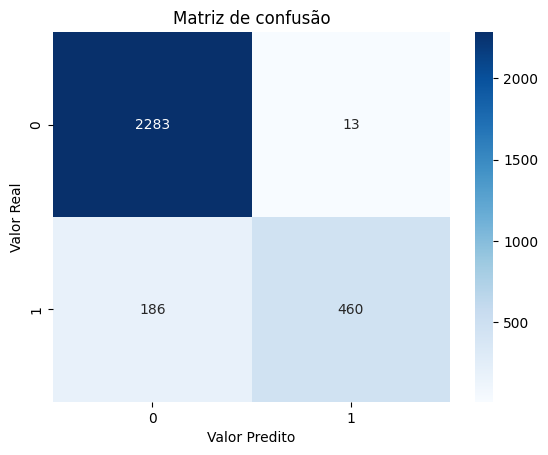

                            Feature  Importance
0                   ratio_renda_emp    0.126243
1                     renda_cliente    0.101049
2                   nota_emprestimo    0.091671
3       percentual_renda_emprestimo    0.089395
4             taxa_juros_emprestimo    0.064645
5                retorno_emprestimo    0.053663
6                 media_valemp_nota    0.040417
7          posse_residencia_cliente    0.035702
8             ratio_emprego_credito    0.032968
9            media_renda_finalidade    0.032249
10            std_valemp_residencia    0.032147
11                 valor_emprestimo    0.031277
12          media_valemp_finalidade    0.027645
13            tempo_emprego_cliente    0.027219
14                    idade_cliente    0.026769
15             std_renda_residencia    0.026030
16            finalidade_emprestimo    0.024928
17                EFD_tempo_emprego    0.024113
18                        EFD_idade    0.021368
19            tempo_credito_cliente    0

In [18]:
# utilizar este para comparar com o de baixo
# 0.938 / 0.934
randomforestclassifier = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight=pesos, random_state=47)

rf_treinado, _, _, _  = treinar_modelo(randomforestclassifier, X, y, True, True)

In [24]:
xgbclassifier = XGBClassifier(n_estimators=30, random_state=47)

xgboost_treinado, _, _, _  = treinar_modelo(xgbclassifier, X, y, True, True)

TypeError: 'XGBClassifier' object is not callable

In [25]:
gradientboostingclassifier = GradientBoostingClassifier(n_estimators=30, random_state=47)

gradientboost_treinado, _, _, _  = treinar_modelo(gradientboostingclassifier, X, y, True, True)

TypeError: 'GradientBoostingClassifier' object is not callable

### Análise dos modelos e respectivas Features Importances
Para evitar overfitting e capturar ruídos dos dados, preferimos verificar a importância das features em cada modelo e tratar as piores posteriormente. Os modelos abaixo foram treinados com 10 folds no StratifiedKFold (SKF) em razão do desbalanceamento de classes, situação em que o SKF lida bem na distribuição de folds em treino e teste estratificando-os.
- Random Forest Classifier:
    - Precisão: 
    - Acurácia: 
    - Feature Importance:
        - x
        - x
        - x
        - x
        - x 
- XGBoost Classifier:
    - Precisão:
    - Acurácia: 
    - Feature Importance:
        - x
        - x
        - x
        - x
        - x 
- Gradient Boosting Classifier:
    - Precisão:
    - Acurácia: 
    - Feature Importance:
        - x
        - x
        - x
        - x
        - x 

 ### Feature Selection
- RFE (Recursive Feature Elimination)
    - Testamos manualmente a quantidade de features cuja métrica utilizada foi a área abaixo da curva entre precisão e revocação (pr_auc).

In [39]:
rfe_report(randomforestclassifier, 14, 24)

Precision Recall AUC:  0.8793016487954224
Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'std_valemp_residencia', 'media_renda_finalidade']


No RandomForestClassifier obtemos:
- com 24 features: xxx
- com 22 features: 0.8772438054175142
- com 20 features: 0.8793445351672696
- com 18 features: 0.8773819569507606
- com 16 features: 0.8784599758567393
- **com 14 features: 0.8793016487954224**
- com 12 features: 0.8778431223281996

O melhor resultado foi obtido com 14 features e pr_auc de: 0.8793016487954224

In [40]:
# Definir o modelo base e o seletor RFE
rfe_report(xgbclassifier, 14, 24)

TypeError: 'XGBClassifier' object is not callable

No XGBClassifier obtemos:
- com 24 features: xxx
- com 22 features: xxx
- com 20 features: xxx
- com 18 features: xxx
- com 16 features: xxx
- com 14 features: xxx
- com 12 features: xxx

O melhor resultado foi obtido com xx features e pr_auc de: xxx

In [ ]:
rfe_report(gradientboostingclassifier, 14, 24)

No GradientBoostingClassifier obtemos:
- com 24 features: xxx
- com 22 features: xxx
- com 20 features: xxx
- com 18 features: xxx
- com 16 features: xxx
- com 14 features: xxx
- com 12 features: xxx

O melhor resultado foi obtido com xx features e pr_auc de: xxx

### Tunagem de Hiperparâmetros
Optamos por utilizar a pesquisa bayesiana da biblioteca Optuna


In [65]:
# Optuna -> RandomForestClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # definir o modelo Random Forest com hiperparâmetros da tentativa atual
    modelo = RandomForestClassifier(
        criterion='entropy',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=pesos, # peso das classes
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X, y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc
    
    #metrica = roc_auc_score(y_test, y_pred_proba)
    
    #return metrica

In [66]:
# Registrar o tempo de início do estudo
#start_time = datetime.datetime.now()

# executando o estudo de otimização no random forest classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_random_forest = RandomForestClassifier(**study.best_params)

# Registrar o tempo de término do estudo
#end_time = datetime.datetime.now()

# Calcular a duração do estudo
#duration = end_time - start_time
#print("Tempo total de execução do estudo:", duration)

print("Melhores hiperparâmetros: ", study.best_params)

[I 2024-07-17 11:30:44,279] A new study created in memory with name: no-name-35ee4bc3-01b6-4204-9c5d-6154821c84da
[I 2024-07-17 11:33:40,809] Trial 0 finished with value: 0.8606978317094927 and parameters: {'n_estimators': 253, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 0.19324722525987623}. Best is trial 0 with value: 0.8606978317094927.
[I 2024-07-17 11:41:12,364] Trial 1 finished with value: 0.8866864158152606 and parameters: {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': 0.8029519304448294}. Best is trial 1 with value: 0.8866864158152606.
[I 2024-07-17 11:45:02,599] Trial 2 finished with value: 0.8785054126139438 and parameters: {'n_estimators': 160, 'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': 0.30022065133102777}. Best is trial 1 with value: 0.8866864158152606.
[I 2024-07-17 11:55:21,901] Trial 3 finished with value: 0.8968045651907842 and parameters:

Melhores hiperparâmetros:  {'n_estimators': 254, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.6469137671892833}


In [67]:
# Optuna -> XGBoostClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # definir o modelo XGBoost com os hiperparâmetros da tentativa atual
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X, y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [68]:
# executando o estudo de otimização no xgboost
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_xgboost = XGBClassifier(**study.best_params)

print("Melhores hiperparâmetros: ", study.best_params)

[I 2024-07-17 15:55:49,512] A new study created in memory with name: no-name-d03ed845-1611-4803-bbdb-3c5635e88e18


[I 2024-07-17 15:55:58,605] Trial 0 finished with value: 0.8927941409974938 and parameters: {'n_estimators': 239, 'max_depth': 18, 'learning_rate': 0.8442500466935782, 'gamma': 0.16270123997724126}. Best is trial 0 with value: 0.8927941409974938.
[I 2024-07-17 15:56:03,455] Trial 1 finished with value: 0.9074096142039306 and parameters: {'n_estimators': 148, 'max_depth': 5, 'learning_rate': 0.16689319418508428, 'gamma': 0.7501246607330952}. Best is trial 1 with value: 0.9074096142039306.
[I 2024-07-17 15:56:06,223] Trial 2 finished with value: 0.8644279162656957 and parameters: {'n_estimators': 92, 'max_depth': 2, 'learning_rate': 0.16923050670950382, 'gamma': 0.23785261858532702}. Best is trial 1 with value: 0.9074096142039306.
[I 2024-07-17 15:56:12,407] Trial 3 finished with value: 0.8865972128360476 and parameters: {'n_estimators': 273, 'max_depth': 2, 'learning_rate': 0.15645069356596103, 'gamma': 0.3086956222488498}. Best is trial 1 with value: 0.9074096142039306.
[I 2024-07-17 1

Melhores hiperparâmetros:  {'n_estimators': 212, 'max_depth': 3, 'learning_rate': 0.6636941533226526, 'gamma': 0.4260857095995374}


In [69]:
# Optuna -> Gradient Boosting Classifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # ['auto', 'sqrt', 'log2']
    
    modelo = GradientBoostingClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=47
    )

    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X, y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [70]:
# executando o estudo de otimização no gradient boosting
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_gradient_boost = GradientBoostingClassifier(**study.best_params)

print("Melhores hiperparâmetros: ", study.best_params)

[I 2024-07-17 15:58:38,189] A new study created in memory with name: no-name-20c055a7-fa48-4782-8e29-a8695ed3691c
[I 2024-07-17 16:08:09,120] Trial 0 finished with value: 0.839857124681285 and parameters: {'n_estimators': 191, 'max_depth': 7, 'learning_rate': 0.8790714410472645, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 0.8769120925297589}. Best is trial 0 with value: 0.839857124681285.
[I 2024-07-17 16:18:22,580] Trial 1 finished with value: 0.9112850218501477 and parameters: {'n_estimators': 87, 'max_depth': 15, 'learning_rate': 0.23998897167976585, 'min_samples_split': 7, 'min_samples_leaf': 17, 'max_features': 0.9382173920487543}. Best is trial 1 with value: 0.9112850218501477.
[I 2024-07-17 16:28:47,282] Trial 2 finished with value: 0.9104261589061075 and parameters: {'n_estimators': 82, 'max_depth': 14, 'learning_rate': 0.1033863318727539, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.8296563476919961}. Best is trial 1 with value: 0.911285

Melhores hiperparâmetros:  {'n_estimators': 212, 'max_depth': 13, 'learning_rate': 0.5861968824622992, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 0.79471308745148}


### Treinando os modelos com os melhores hiperparâmetros

Média da Precisão (Weighted): 0.936
Média da Revocação (Weighted): 0.933


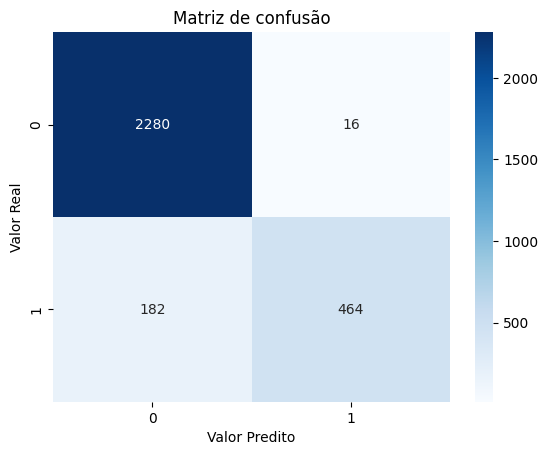

In [73]:
# treinando o random forest classifier
# precision_recall_curve baixo: {'n_estimators': 78, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 0.8632489057911502}
# precisão/revocação: 0.854 / 0.847

# precision_recall_curve alto: {'n_estimators': 92, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 0.6245539058055509}
# precisão/revocação: 0.930 / 0.929

# {'n_estimators': 254, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.6469137671892833}
# precisão/revocação: 0.936 / 0.933
randomforestclassifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=254,
    max_depth=22,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=0.6469137671892833,
    class_weight=pesos, # peso das classes
    random_state=47
)

rf_treinado, _, _, _ = treinar_modelo(randomforestclassifier, X, y, True)

In [74]:
with open('rf_treinado.pkl', mode='wb') as f:
    pickle.dump(rf_treinado, f)

Média da Precisão (Weighted): 0.933
Média da Revocação (Weighted): 0.932


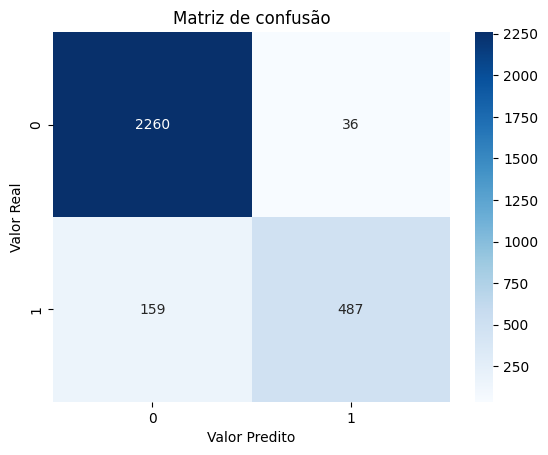

In [72]:
# treinando o xgboost classifier
# precision_recall_curve baixo:  {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.0336961292658704, 'gamma': 0.7381414333194561}
# precisão/revocação: 0.878 / 0.859

# precision_recall_curve alto: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.45563977171150727, 'gamma': 0.44483996937014203}
# precisão/revocação: 0.936 / 0.935

# {'n_estimators': 212, 'max_depth': 3, 'learning_rate': 0.6636941533226526, 'gamma': 0.4260857095995374}
# precisão/revocação: 0.933 / 0.932
xgbclassifier = XGBClassifier(
    n_estimators=212,
    max_depth=3,
    learning_rate=0.6636941533226526,
    gamma=0.4260857095995374,
    random_state=47
)

xgb_treinado, _, _, _ = treinar_modelo(xgbclassifier, X, y, True)


In [75]:
with open('xgb_treinado.pkl', mode='wb') as f:
    pickle.dump(xgb_treinado, f)

Média da Precisão (Weighted): 0.935
Média da Revocação (Weighted): 0.935


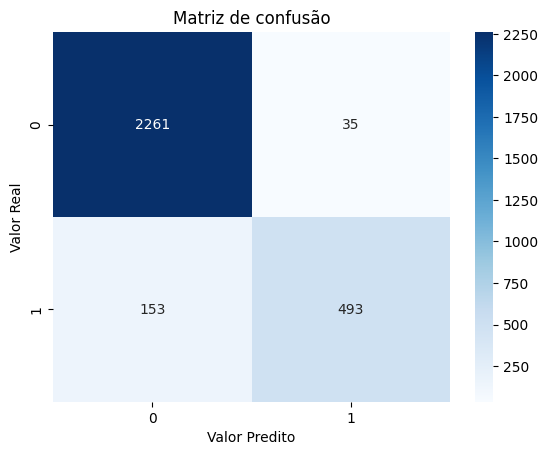

In [71]:
# treinando o gradient boosting classifier
# precision_recall_curve baixo:  {'n_estimators': 108, 'max_depth': 14, 'learning_rate': 0.9462393751287829, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 0.6103354083048557}
# precisão/revocação: 0.868 / 0.866

# precision_recall_curve alto: {'n_estimators': 211, 'max_depth': 15, 'learning_rate': 0.20832695130063011, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.9883894035240187}
# precisão/revocação: 0.940 / 0.938

# {'n_estimators': 212, 'max_depth': 13, 'learning_rate': 0.5861968824622992, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 0.79471308745148}
# precisão/revocação: 0.935 / 0.935
gradientboostingclassifier = GradientBoostingClassifier(
    n_estimators=212,
    max_depth=13,
    learning_rate=0.5861968824622992,
    min_samples_split=18,
    min_samples_leaf=9,
    max_features=0.79471308745148,
    random_state=47
)

gbc_treinado, _, _, _ = treinar_modelo(gradientboostingclassifier, X, y, True)


In [76]:
with open('gbc_treinado.pkl', mode='wb') as f:
    pickle.dump(gbc_treinado, f)

### Modelo escolhido

In [ ]:
# escolher o modelo e exibir a performance dele aqui

In [ ]:
# salvar o modelo em um arquivo pickle
# with open('modelo.pkl', mode='wb') as f:
#    pickle.dump(modelo_treinado, f)

# Análise de Negócio
Revisando a performance do modelo escolhido:
- Score Cross Validation: 
- Average Precision: 
- Precision Score: 
- Recall Score: 
- F1 Score: 
- ROC AUC Score: 

O Recall nos diz que de todos os clientes que de fato não pagaram, o modelo conseguiu acertar XX.xx% dos casos. Contudo, o modelo acertou apenas YY.yy% dos casos em que ele previu que os clientes não pagariam.

Inserindo em um contexto para visualizar a solução da aplicabilidade deste modelo no negócio, temos a proposta abaixo: ~~para os clientes que não possuem histórico de inadimplência~~

Como não sabemos em quanto tempo um cliente pagará o empréstimo ou quanto está pagando por período, utilizaremos o desconto de juros fixo
_______________________________________________
**"Receba 2% de Desconto de Juros Fixo ao pagar o seu empréstimo em dia!"**
_______________________________________________

Supondo que com essa estratégia os clientes que não pagariam, permaneceram pagando por mais 5 meses.
Dito isso, precisamos calcular o lucro líquido e bruto com estes clientes que posteriormente deixariam de pagar o empréstimo.

Devemos selecionar no banco de dados os clientes em que a previsão foi de clientes inadimplentes:

In [ ]:
# selecionar a predição do modelo
# executar a intersecção da predição com o real para criar um dataframe só com a intersecção de pred x real
# localizar os índices destes clientes
# atribuir o dataframe de teste à uma variável: df_X_test_copy
# reproduzir em df_X_test_copy.head()

Aplicando o desconto de 2% no juros anual e multiplicando por 5. Assim saberemos quanto obtemos com a retenção destes clientes.

In [ ]:
# df_X_test_copy['juros_emprestimo'] = df[df['juros_emprestimo'] == df['status_emprestimo'] == 1]

# definir em quanto tempo os clientes iriam pagar os empréstimos com base no percentual_renda_emprestimo
# lucro_liquido = (df_X_test_copy['juros_emprestimo'].values*0.8)*(df_X_test_copy['valor_emprestimo'].values/12*5).sum()

In [ ]:
# lucro_bruto = (df_X_test_copy['valor_emprestimo'].values).sum() - lucro_liquido
# verificar o valor se eles tivessem não pago por esses 5 meses e comparar com se tivessem pago para fazer o valor bruto

## Resultado
Lucro Líquido: R$

Perdas: R$

Lucro Bruto: R$